In [1]:
import numpy as np
import gdsfactory as gf
import gdsfactory.components as pdk
import cornerstone_pdk as cs_pdk # type: ignore
from gdsfactory.typings import ComponentSpec, CrossSectionSpec

In [2]:
# Cornerstone rib cross section
xs = cs_pdk.cornerstone_rib()

# fiber array pitch
fa_pitch = 127.0

# Cornerstone Library
# gc = cs_pdk.gc_cornerstone_pdk()
gc = cs_pdk.gc_focusing_cornerstone_pdk()
mmi1x2 = cs_pdk.mmi1x2_cornerstone_pdk()
mmi2x2 = cs_pdk.mmi2x2_cornerstone_pdk()
wgx = cs_pdk.crossing_cornerstone_pdk()

In [16]:
# functions with Cornerstone components
@gf.cell
def cornerstone_mzi(delta_length: float = 50.0) -> gf.Component:
    bend = gf.components.bend_circular(cross_section=xs)
    mzi = pdk.mzi(delta_length=delta_length, bend=bend, splitter=mmi1x2, combiner=mmi1x2, cross_section=xs)
    return mzi

@gf.cell
def cornerstone_bragg_period(pitch: float = 0.6, ff: float = 0.5, w1: float = 0.45, w2: float = 0.55) -> gf.Component:
    if min(w1, w2, pitch*ff, pitch*(1-ff)) < 0.2:
        print("Error: minimum feature size < 200 nm!")
        return 0
    else:
        c = gf.Component()
        r1 = c << pdk.straight(length=pitch*ff, width=w1, cross_section=xs)
        r2 = c << pdk.straight(length=pitch*(1-ff), width=w2, cross_section=xs)
        r2.connect(port='o1', other=r1.ports['o2'], allow_width_mismatch=True)
        c.add_port('o1', port=r1.ports['o1'])
        c.add_port('o2', port=r2.ports['o2'])
        return c

@gf.cell
def cornerstone_bragg_grating(pitch: float = 0.6, ff: float = 0.5, w1: float = 0.45, w2: float = 0.55, N: int = 100) -> gf.Component:
    dbr = gf.Component()
    period = cornerstone_bragg_period(pitch=pitch, ff=ff, w1=w1, w2=w2)
    dbr.add_ref(period, columns=N, rows=1, column_pitch=pitch)
    dbr.add_port('o1', center=[dbr.xmin, (dbr.ymax+dbr.ymin)/2], orientation=180, cross_section=xs)
    dbr.add_port('o2', center=[dbr.xmax, (dbr.ymax+dbr.ymin)/2], orientation=0, cross_section=xs)
    return dbr

@gf.cell
def cornerstone_mrr(radius: float = 20., gap: float = 0.2, length_rt: float = 20., mrr_type: str = 'all_pass') -> gf.Component:
    mrr = gf.Component()
    if gap < 0.2:
        print("Error: minimum feature size < 200 nm!")
        return 0
    
    len_y = max(0.01, 0.5*(length_rt - 2*np.pi*radius))

    if mrr_type == 'all_pass':
        mrr = pdk.ring_single(gap=gap, radius=radius, length_x=0.01, length_y=len_y, bend='bend_circular', cross_section=xs)
    else:
        mrr = pdk.ring_double(gap=gap, radius=radius, length_x=0.01, length_y=len_y, bend='bend_circular', cross_section=xs)
    return mrr

In [4]:
# top cell
top = gf.Component('TOP')

# floor plan
top << gf.components.rectangle(size=(6000., 3000.), centered=True, layer=(99,0))

TOP: ports ['e1', 'e2', 'e3', 'e4'], rectangle_S6000_3000_L9_b4bd1af7: ports ['e1', 'e2', 'e3', 'e4'], 0 instances

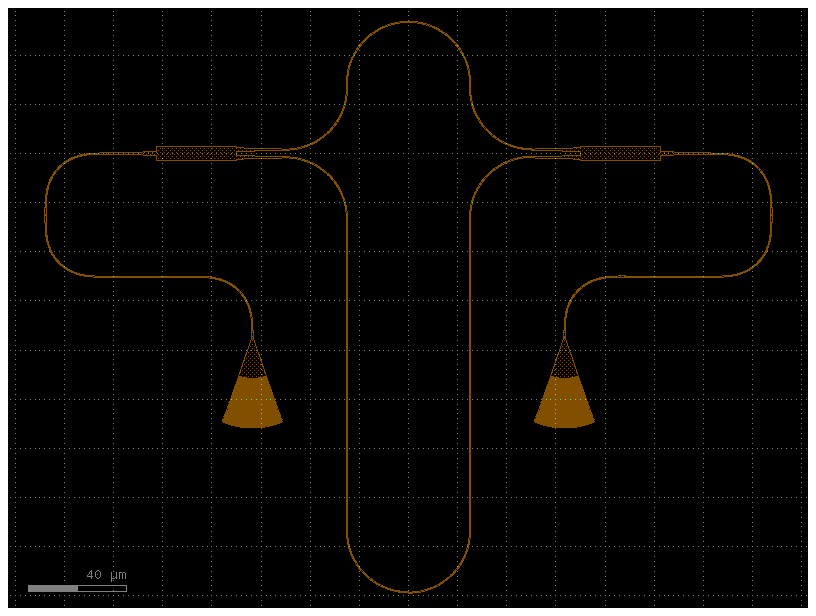

In [5]:
# layout of an MZI
c = gf.Component('MZI')

mzi = c << cornerstone_mzi(delta_length=250.0)
mzi.movex(-(mzi.xmin+mzi.xmax)/2)

# manually route grating couplers to MZI
gc1 = c << gc
gc1.rotate(angle=-90)
gc1.movex(-fa_pitch/2)
gc1.movey(-75.)

gc2 = c << gc
gc2.rotate(angle=-90)
gc2.movex(fa_pitch/2)
gc2.movey(-75.)

gf.routing.route_single(c, port1=gc1.ports['o1'], port2=mzi.ports['o1'], cross_section=xs)
gf.routing.route_single(c, port1=gc2.ports['o1'], port2=mzi.ports['o2'], cross_section=xs)

c.plot()

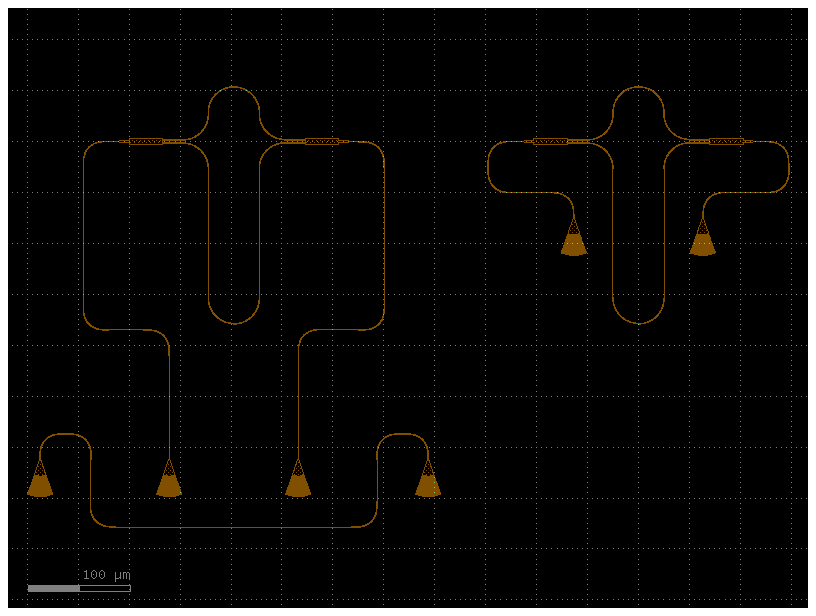

In [6]:
# make another MZI and connect with Fiber array
mzi2 = cornerstone_mzi(delta_length=250.0)
fa_mzi = c << gf.routing.add_fiber_array(component=mzi2, grating_coupler=gc, cross_section=xs, pitch=fa_pitch)
fa_mzi.movex(-500.)

c.plot()

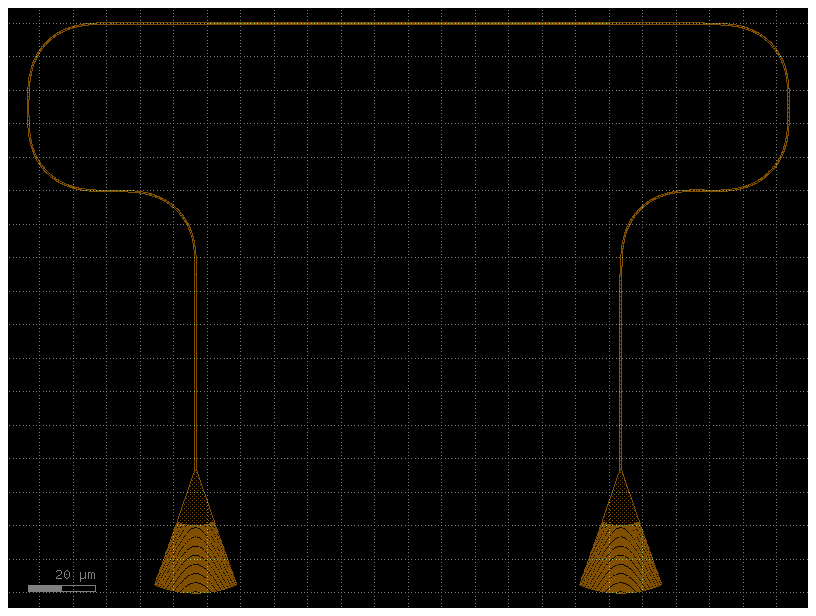

In [9]:
# layout of a bragg grating
c2 = gf.Component('DBR')

dbr = cornerstone_bragg_grating(w1=0.4, w2=0.5, N = 200)
fa_dbr = c2 << gf.routing.add_fiber_array(component=dbr, grating_coupler=gc, cross_section=xs, pitch=fa_pitch, with_loopback=False)
fa_dbr.movex(300.)

c2.plot()

/ihome/nyoungblood/nay32/.local/lib/python3.11/site-packages/gdsfactory/pdk.py:442: UserWarning: {'radius': 15} are ignored for cross_section 'cornerstone_rib'
  warnings.warn(


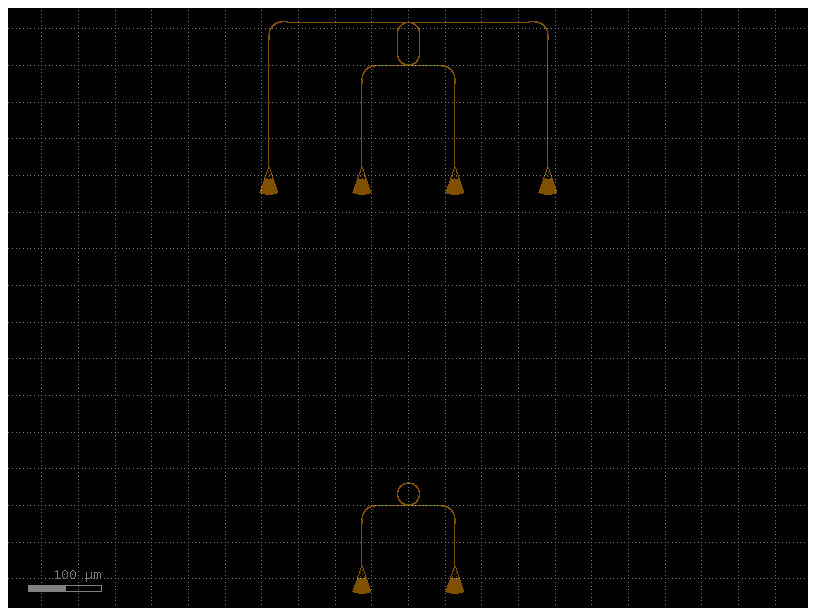

In [17]:
# layout of ring resonator
c3 = gf.Component('MRR')

mrr_ap = cornerstone_mrr(radius=15)
fa_mrr_ap = c3 << gf.routing.add_fiber_array(component=mrr_ap, grating_coupler=gc, cross_section=xs, pitch = fa_pitch, with_loopback=False)
fa_mrr_ap.movey(-300.)

mrr_ad = cornerstone_mrr(radius=15, gap=0.2, length_rt=150., mrr_type='add_drop')
fa_mrr_ad = c3 << gf.routing.add_fiber_array(component=mrr_ad, grating_coupler=gc, cross_section=xs, pitch = fa_pitch, with_loopback=False)
fa_mrr_ad.movey(300.)

c3.plot()

In [ ]:
# add cells to TOP
top << c
top << c2
top << c3
top.plot()
top.write_gds("cs_layout.gds")